In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import math

from sklearn.metrics import log_loss, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

### Data Prep

In [120]:
COMP_PATH = "/kaggle/input/icr-identify-age-related-conditions"
train = pd.read_csv(f"{COMP_PATH}/train.csv")
test = pd.read_csv(f"{COMP_PATH}/test.csv")
sample_submission = pd.read_csv(f"{COMP_PATH}/sample_submission.csv")
greeks = pd.read_csv(f"{COMP_PATH}/greeks.csv")

In [121]:
train.fillna(train.median(), inplace=True)
test.fillna(test.median(), inplace=True)
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [122]:
cols = train.columns
feat_cols = cols[1:]
num_cols = train.select_dtypes(include=['float64']).columns
print("No of Columns:", len(cols))

No of Columns: 58


### Metric

In [123]:
def competition_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    return (log_loss_0 + log_loss_1)/2

def balanced_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    return balanced_log_loss/(N_0+N_1)

In [124]:
def lgb_metric(y_true, y_pred):
    return 'balanced_log_loss', balanced_log_loss(y_true, y_pred), False

### Feature Engineering

In [125]:
# Label encoding
train['EJ'] = train['EJ'].map({'A': 0, 'B': 1})
test['EJ']  = test['EJ'].map({'A': 0, 'B': 1})

In [126]:
# lgbにスケーリングは不要
"""
scaler = StandardScaler()
df, test_df = train.copy(), test.copy()
new_num_cols = train.select_dtypes(include=['float64']).columns
df[new_num_cols] = scaler.fit_transform(train[new_num_cols])
test_df[new_num_cols] = scaler.transform(test[new_num_cols])
df
"""

"\nscaler = StandardScaler()\ndf, test_df = train.copy(), test.copy()\nnew_num_cols = train.select_dtypes(include=['float64']).columns\ndf[new_num_cols] = scaler.fit_transform(train[new_num_cols])\ntest_df[new_num_cols] = scaler.transform(test[new_num_cols])\ndf\n"

# Stratified Down Sampling

In [127]:
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [128]:
# 年齢カラムの確認
train["BN"].unique()

array([22.5984, 19.4205, 26.4825, 23.6577, 24.0108, 10.2399, 17.655 ,
       20.8329, 20.4798, 21.8922, 25.4232, 24.717 , 18.7143, 22.9515,
       19.7736,  9.8868, 22.2453, 25.7763, 18.3612, 21.5391, 26.1294,
       28.248 , 27.1887, 16.5957, 15.8895, 17.3019, 18.0081, 21.186 ,
       27.5418, 20.1267, 16.2426, 15.1833, 25.0701, 19.0674, 14.124 ,
       16.9488, 23.3046, 12.0054, 26.8356, 12.3585, 24.3639, 28.6011,
       27.8949, 11.2992, 13.0647, 14.4771, 15.5364, 13.7709, 10.593 ,
       28.9542, 13.4178, 29.3073, 10.9461])

### float to int
参考 : https://www.kaggle.com/code/raddar/convert-icr-data-to-integers

BNカラムをint型に変更し、年齢をわかりやすく表示

In [129]:
BN_SCALER = 0.3531
train["BN"] = train["BN"]/BN_SCALER
train["BN"].unique()

array([64., 55., 75., 67., 68., 29., 50., 59., 58., 62., 72., 70., 53.,
       65., 56., 28., 63., 73., 52., 61., 74., 80., 77., 47., 45., 49.,
       51., 60., 78., 57., 46., 43., 71., 54., 40., 48., 66., 34., 76.,
       35., 69., 81., 79., 32., 37., 41., 44., 39., 30., 82., 38., 83.,
       31.])

In [130]:
train["BN"].describe()

count    617.000000
mean      60.661264
std        9.850688
min       28.000000
25%       55.000000
50%       60.000000
75%       67.000000
max       83.000000
Name: BN, dtype: float64

### 3大疾病について

日本における三大疾病の死亡時の年齢の分布。
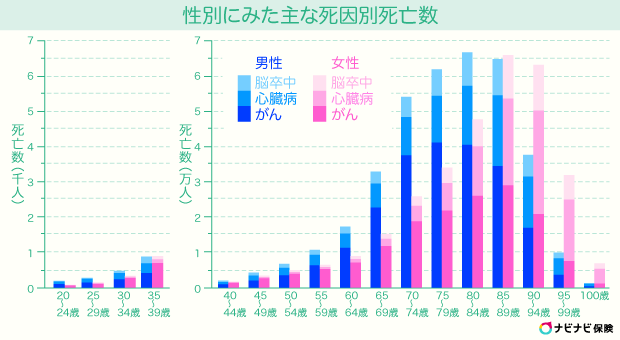!


死亡率だし、一概に発症と同じとは言えないけど高い相関はあると仮定。これを軸に年齢を4 ~ 6くらいに分けたい

ざっくりだけど
- 〜40歳
- 40 ~ 60歳
- 60 ~ 70歳
- 70以上

当たりが妥当な気がする

たけるのEDA見てもそこまで上記ラベリングに対して違和感はない。
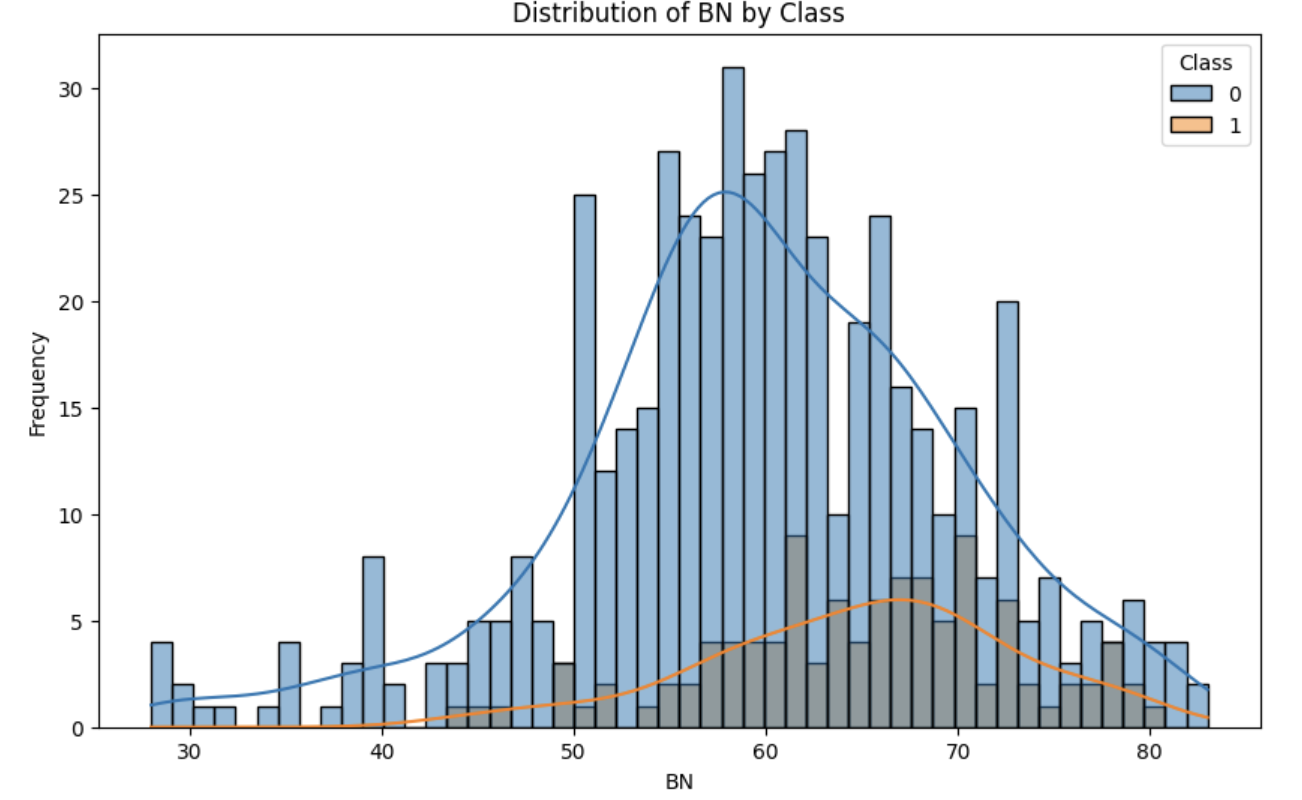
issue : https://github.com/meltyyyyy/ICR-2023/issues/6#issuecomment-1620831080

In [131]:
# 上記条件でラベリング
train["BN_label"] = 0
for i in range(len(train)):
    if (train.loc[i, "BN"] > 40) & (train.loc[i, "BN"] <= 60):
        train.loc[i, "BN_label"] = 1
    elif (train.loc[i, "BN"] > 60) & (train.loc[i, "BN"] <= 70):
        train.loc[i, "BN_label"] = 2
    elif (train.loc[i, "BN"] > 70) & (train.loc[i, "BN"] <= 80):
        train.loc[i, "BN_label"] = 3
train["BN_label"].unique()

array([2, 1, 3, 0])

### stratified downsampling

シンプルにラベル0のデータを抽出して、sklearnのstratified shaffle split使って1/nにダウンサンプリングする実装を行う。

参考 : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

In [132]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=0)

In [133]:
# 今回はtrain_indexのもののみを使用
# train_indexにより抽出されたデータサイズは、元のデータの1/4
class0_train = train[train["Class"]==0]
for i, (train_index, test_index) in enumerate(sss.split(class0_train, class0_train["BN_label"])):
    print(train_index)
    print(len(train_index))

[443 267 400 204 357 381 479 276 220 446 219 434 103 319 448 231 500 429
  30 424 186 278 363 413  68 164 416 326 476  41 395 228 370 376  98 160
 499 171 127 263   2 438 350  80 201 274 128 172 177 302 122  93 178 332
 211 359 291  97 389 139 299 234 396 298 259  15 344 215 140 444 277 420
 484 405 421 331 273  89 208 166  42 427 249  36 481 304 281 182 253 387
 412 402 159 187 492  34 377 268 433 255  32 488  43 422  58 203 173 417
 124 362 269  12 337 472 503 445 183 340 138  46 485 469 227  90  22 130
 205  61 282 323 452 349 419 254 266  57 437 403 222 113 217 436 483 184
 430 309 200 197 141 410 161 176 471 378 112 324  56 354 153 329  86 170
 426  45  37  18 251 283 101 300 221 398 180  70  16 315 455   0 252 327
 462 216 123  69 233 440 456 287  20 373 392 311 185 404   7 336 431 144
  17  10 475 409  33 190 116  54 126  67  75 179 346 418 223 271  21 478
  24 415 504  74 372 435  49 342 454 156 152 147 333 125 108 486 343 288
 243 207  79  95 285 239 382  19 401 198 494 270   

In [134]:
train["Class"].sum()

108

In [135]:
under_sampled_df = class0_train.iloc[train_index]
len(under_sampled_df)

381

In [136]:
df = pd.concat([under_sampled_df, train[train["Class"] == 1]])

In [137]:
df.reset_index(inplace=True)
df.head()

,index,Id,AB,AF,AH,AM,AR,AX,AY,AZ,...,FR,FS,GB,GE,GF,GH,GI,GL,Class,BN_label
0,540,da6c7e4e124d,0.388843,2185.51894,85.200147,93.473654,8.138688,6.493647,0.025578,8.028748,...,1.13767,0.067730,8.269478,72.611063,8089.194681,36.808132,43.410216,2.019600,0,1
1,326,809087be105e,0.931514,2919.81954,85.200147,35.757962,8.269788,4.571244,0.157731,11.885572,...,0.49706,0.101595,12.055392,72.611063,8899.349148,15.910996,20.789476,21.978000,0,2
2,483,c38cbd7f61dd,0.495668,3268.01398,85.200147,14.196648,8.138688,4.066281,0.035322,7.864896,...,1.06865,0.325104,8.827598,72.611063,1200.302145,25.745599,8.701076,0.112280,0,3
3,241,600c445d3351,0.213650,2923.50278,85.200147,12.394194,8.138688,4.482654,0.025578,4.613064,...,1.20292,0.067730,18.287732,72.611063,2084.744628,29.421947,49.562440,0.124326,0,2
4,435,acd97f3380e4,0.692226,2709.13434,124.730298,30.189556,8.138688,6.896731,0.048720,20.279836,...,1.28557,0.081276,20.389984,72.611063,595.765044,31.286168,55.263278,0.125788,0,2


In [138]:
df.drop(["index"], axis=1, inplace=True)
len(df)

489

### CV

In [139]:
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
df['fold'] = -1

for fold, (train_idx, test_idx) in enumerate(kf.split(df, df["BN_label"])):
    df.loc[test_idx, 'fold'] = fold

df.groupby('fold')["Class"].value_counts()

fold  Class
0     0        83
      1        15
1     0        79
      1        19
2     0        75
      1        23
3     0        80
      1        18
4     0        64
      1        33
Name: Class, dtype: int64

### Training

In [140]:
final_valid_predictions = {}
final_test_predictions = []
scores = []
log_losses = []
balanced_log_losses = []
weights = []

for fold in range(5):
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]
    valid_ids = valid_df.Id.values.tolist()

    X_train, y_train = train_df.drop(['Id', 'Class', 'fold'], axis=1), train_df['Class']
    X_valid, y_valid = valid_df.drop(['Id', 'Class', 'fold'], axis=1), valid_df['Class']
    X_train.drop(["BN_label"], axis=1, inplace=True)
    X_valid.drop(["BN_label"], axis=1, inplace=True)
    
    lgb = LGBMClassifier(boosting_type='goss', learning_rate=0.06733232950390658, n_estimators = 50000, 
                         early_stopping_round = 300, random_state=42,
                        subsample=0.6970532011679706,
                        colsample_bytree=0.6055755840633003,
                         class_weight='balanced',
                         metric='none', is_unbalance=True, max_depth=8)
    
    lgb.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=1000,
            eval_metric=lgb_metric)
    
    y_pred = lgb.predict_proba(X_valid)
    preds_test  = lgb.predict_proba(test.drop(['Id'], axis=1).values)
    
    final_test_predictions.append(preds_test)
    final_valid_predictions.update(dict(zip(valid_ids, y_pred)))

    logloss = log_loss(y_valid, y_pred)
    balanced_logloss = balanced_log_loss(y_valid, y_pred[:, 1])
    log_losses.append(logloss)
    balanced_log_losses.append(balanced_logloss)
    weights.append(1/balanced_logloss)
    
    print(f"Fold: {fold}, log loss: {round(logloss, 3)}, balanced los loss: {round(balanced_logloss, 3)}")

print()
print("Log Loss")
print(log_losses)
print(np.mean(log_losses), np.std(log_losses))
print()
print("Balanced Log Loss")
print(balanced_log_losses)
print("MEAN : ", np.mean(balanced_log_losses), "STD : ", np.std(balanced_log_losses))
print()
print("Weights")
print(weights)

Fold: 0, log loss: 0.241, balanced los loss: 0.122
Fold: 1, log loss: 0.204, balanced los loss: 0.165
Fold: 2, log loss: 0.101, balanced los loss: 0.09
Fold: 3, log loss: 0.243, balanced los loss: 0.167
Fold: 4, log loss: 0.183, balanced los loss: 0.183

Log Loss
[0.2406143433730379, 0.2036362009001969, 0.10083774417606796, 0.24253327502906336, 0.18289332579340814]
0.19410297785435485 0.051814560233351084

Balanced Log Loss
[0.12205471487516421, 0.16487030986518764, 0.09028501278059935, 0.16704096179844805, 0.18300132594449228]
MEAN :  0.1454504650527783 STD :  0.03418752792098041

Weights
[8.193046872648758, 6.0653734490927285, 11.076035426057805, 5.986555568367727, 5.464441281170382]


In [141]:
test_preds = np.zeros((test.shape[0],2))
for i in range(5):
    test_preds[:, 0] += weights[i] * final_test_predictions[i][:, 0]
    test_preds[:, 1] += weights[i] * final_test_predictions[i][:, 1]
test_preds /= sum(weights)
test_preds

array([[0.60825429, 0.39174571],
       [0.60825429, 0.39174571],
       [0.60825429, 0.39174571],
       [0.60825429, 0.39174571],
       [0.60825429, 0.39174571]])

In [142]:
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ['Id', 'class_0', 'class_1']
final_valid_predictions.to_csv(r"oof.csv", index=False)

test_dict = {}
test_dict.update(dict(zip(test.Id.values.tolist(), test_preds)))
submission = pd.DataFrame.from_dict(test_dict, orient="index").reset_index()
submission.columns = ['Id', 'class_0', 'class_1']                       

submission.to_csv(r"submission.csv", index=False)
submission

,Id,class_0,class_1
0,00eed32682bb,0.608254,0.391746
1,010ebe33f668,0.608254,0.391746
2,02fa521e1838,0.608254,0.391746
3,040e15f562a2,0.608254,0.391746
4,046e85c7cc7f,0.608254,0.391746
